In [23]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import pickle
from Rubiks.agent import Agent
from Rubiks.state import State
from Rubiks.utils import move, num_solved_sides, num_pieces_correct_side, n_move_state
from cube_visualization import draw_cube

In [24]:
with open('pattern_database.pkl', 'rb') as f:
    pattern_database = pickle.load(f)

agent = Agent(QValues=pattern_database)

# Define the function to update the Q-values using the Q-learning algorithm:
### - The function takes the following inputs:
   1. agent
   2. current state
   3. action
   4. reward
   5. next state
 - It calculates the hash of the current state and action to form the state-action pair.
 - It computes the maximum Q-value for the next state over all possible actions.
 - The Q-value for the current state-action pair is updated using the Q-learning formula:
 
   Q(s, a) = Q(s, a) + α * (reward + γ * max(Q(s', a')) - Q(s, a))
 
   where:
   - Q(s, a) is the Q-value of the current state-action pair
   - reward is the reward received after taking the action
   - γ (GAMMA) is the discount factor
   - max(Q(s', a')) is the maximum Q-value of the next state over all possible actions
   - α (ALPHA) is the learning rate

###  The hyperparameters for the Q-learning algorithm.
 - ALPHA (learning rate): Determines how much new information overrides the old information.
 - GAMMA (discount factor): Measures the importance of future rewards.
 - EPSILON (exploration rate): The probability of choosing a random action instead of the best-known action.
 - EPSILON_DECAY: The factor by which EPSILON decreases after each episode.
 - MIN_EPSILON: The minimum value that EPSILON can decay to.
 - NUM_EPISODES: The total number of episodes for training.
 - MAX_STEPS: The maximum number of steps allowed per episode.

In [25]:
# Hyperparameters
NUM_EPISODES = 5000
MAX_STEPS = 100
INITIAL_EPSILON = 1.0
MIN_EPSILON = 0.01
EPSILON_DECAY = 0.995
LEARNING_RATE = 0.01
DISCOUNT_FACTOR = 0.99
MEMORY_SIZE = 10000
BATCH_SIZE = 32

the ε-greedy strategy to select actions, balancing exploration and exploitation.

In [22]:
memory = deque(maxlen=MEMORY_SIZE)

epsilon = INITIAL_EPSILON

success_count = 0

def select_action(agent, state, epsilon):
    if random.random() < epsilon:
        return random.choice(agent.actions)
    else:
        return max(agent.actions, key=lambda action: agent.QV.get((state.__hash__(), action), 0))


# The training loop for the Q-learning agent
It runs for a specified number of episodes, where in each episode,
the Rubik's Cube is randomly scrambled, and the agent attempts to solve it using the learned Q-values

In [23]:
for episode in range(NUM_EPISODES):
    state = n_move_state(n=6)
    total_reward = 0
    for step in range(MAX_STEPS):
        action = select_action(agent, state, epsilon)
        next_state = move(state, action)
        reward = agent.reward(state, action)
        memory.append((state, action, reward, next_state))

        if len(memory) > BATCH_SIZE:
            batch = random.sample(memory, BATCH_SIZE)
            for s, a, r, ns in batch:
                future_q = max([agent.QV.get((ns.__hash__(), next_action), 0) for next_action in agent.actions])
                target = r + DISCOUNT_FACTOR * future_q
                agent.QV[(s.__hash__(), a)] = agent.QV.get((s.__hash__(), a), 0) + LEARNING_RATE * (target - agent.QV.get((s.__hash__(), a), 0))
        
        state = next_state
        total_reward += reward
        if num_solved_sides(state) == 6:
            success_count += 1
            break

    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY

    print(f"Episode {episode+1}/{NUM_EPISODES}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

success_rate = (success_count / NUM_EPISODES) * 100
print(f"Success Rate: {success_rate:.2f}%")

with open('updated_pattern_database1.pkl', 'wb') as f:
    pickle.dump(agent.QV, f)


Episode 1/5000, Total Reward: -4.899999999999994, Epsilon: 0.995
Episode 2/5000, Total Reward: -6.999999999999993, Epsilon: 0.990
Episode 3/5000, Total Reward: -10.79999999999998, Epsilon: 0.985
Episode 4/5000, Total Reward: -11.399999999999975, Epsilon: 0.980
Episode 5/5000, Total Reward: -6.299999999999995, Epsilon: 0.975
Episode 6/5000, Total Reward: -10.39999999999998, Epsilon: 0.970
Episode 7/5000, Total Reward: 100.6, Epsilon: 0.966
Episode 8/5000, Total Reward: -11.399999999999977, Epsilon: 0.961
Episode 9/5000, Total Reward: -6.199999999999981, Epsilon: 0.956
Episode 10/5000, Total Reward: -4.2, Epsilon: 0.951
Episode 11/5000, Total Reward: -10.799999999999981, Epsilon: 0.946
Episode 12/5000, Total Reward: -11.799999999999978, Epsilon: 0.942
Episode 13/5000, Total Reward: -6.999999999999993, Epsilon: 0.937
Episode 14/5000, Total Reward: -11.599999999999977, Epsilon: 0.932
Episode 15/5000, Total Reward: -11.999999999999973, Epsilon: 0.928
Episode 16/5000, Total Reward: -11.19999

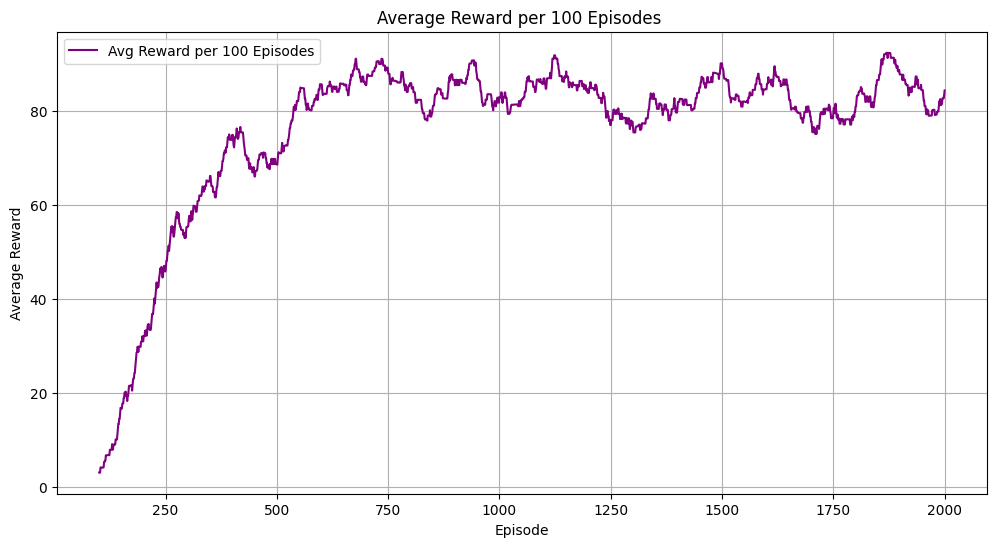

In [20]:
new_data = pd.read_csv('results_training.csv')

filtered_data['Avg Reward per 100 Episodes'] = filtered_data['Total Reward'].rolling(window=100).mean()

plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Episode'], filtered_data['Avg Reward per 100 Episodes'], label='Avg Reward per 100 Episodes', color='purple')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward per 100 Episodes ')
plt.legend()
plt.grid(True)
plt.show()

# focusing on the 2000 first episodes because after the performace is almost stable 


In [21]:
new_data = pd.read_csv('results_training.csv')

early_episodes = new_data[new_data['Episode'] <= 2000]
late_episodes = new_data[(new_data['Episode'] > 2001) & (new_data['Episode'] <= 5000)]

early_mean_reward = early_episodes['Total Reward'].mean()
early_std_reward = early_episodes['Total Reward'].std()
late_mean_reward = late_episodes['Total Reward'].mean()
late_std_reward = late_episodes['Total Reward'].std()

early_summary = f"Early Episodes (1-2000): Mean Reward = {early_mean_reward:.2f}, Std Dev = {early_std_reward:.2f}"
late_summary = f"Late Episodes (2002-5000): Mean Reward = {late_mean_reward:.2f}, Std Dev = {late_std_reward:.2f}"

early_summary, late_summary


('Early Episodes (1-2000): Mean Reward = 74.77, Std Dev = 47.86',
 'Late Episodes (2002-5000): Mean Reward = 85.52, Std Dev = 41.35')

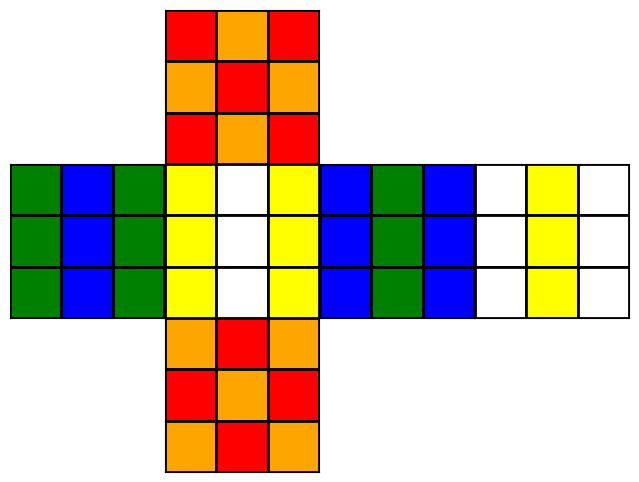

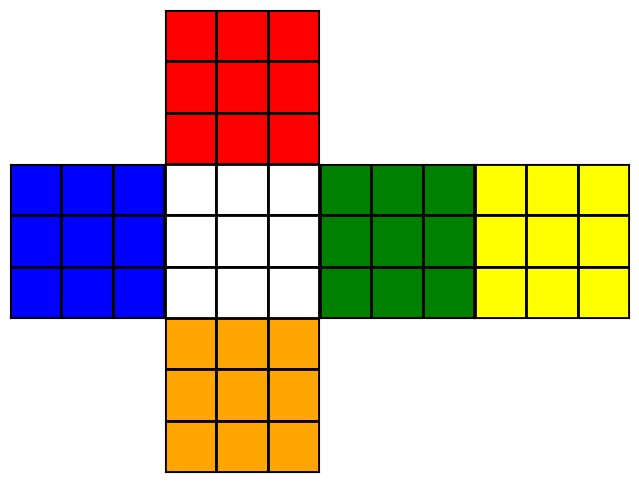

In [29]:
with open('updated_pattern_database1.pkl', 'wb') as f:
    pickle.dump(agent.QV, f)

test_episodes = 100
test_success_count = 0

initial_test_state = n_move_state(n=6)
draw_cube(initial_test_state)  
for episode in range(test_episodes):
    state = initial_test_state if episode == 0 else n_move_state(n=6)
    for step in range(MAX_STEPS):
        action = max(agent.actions, key=lambda action: agent.QV.get((state.__hash__(), action), 0))
        state = move(state, action)
        if num_solved_sides(state) == 6:
            test_success_count += 1
            break

    if episode == test_episodes - 1:
        draw_cube(state)  


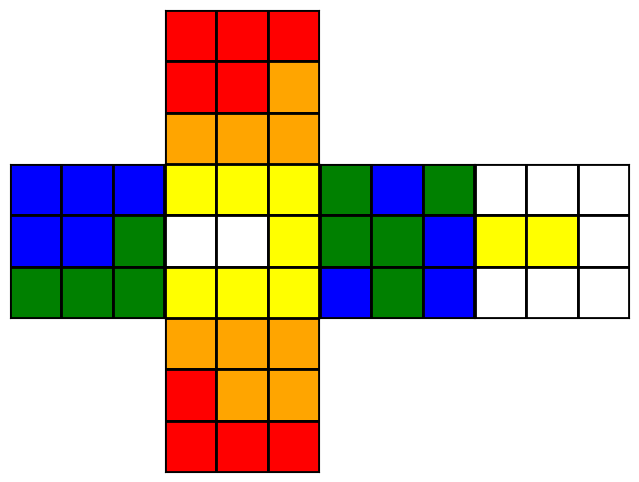

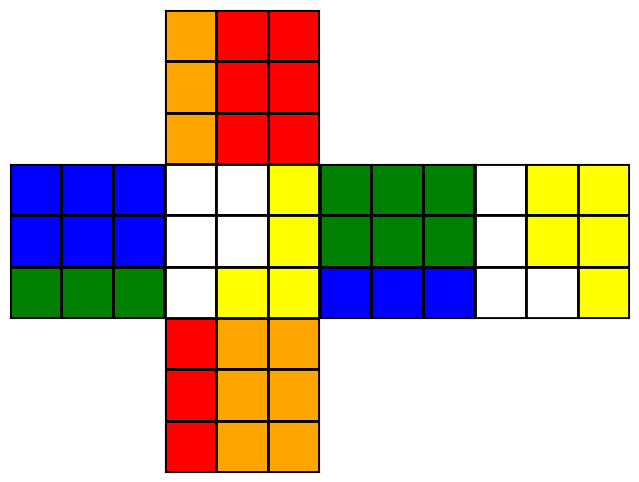

In [70]:
with open('updated_pattern_database1.pkl', 'wb') as f:
    pickle.dump(agent.QV, f)

test_episodes = 100
test_success_count = 0

initial_test_state = n_move_state(n=6)
draw_cube(initial_test_state)  
for episode in range(test_episodes):
    state = initial_test_state if episode == 0 else n_move_state(n=6)
    for step in range(MAX_STEPS):
        action = max(agent.actions, key=lambda action: agent.QV.get((state.__hash__(), action), 0))
        state = move(state, action)
        if num_solved_sides(state) == 6:
            test_success_count += 1
            break

    if episode == test_episodes - 1:
        draw_cube(state)  
